# Character Level Seq2Seq Translation
Uses a really simply recurrent architecture to translate from English to French. Unfortunately performance isn't great, thus far. I would like to explore CLR and Beam Search going forward.

Adapted from https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [0]:
!pip install torch

    100% |████████████████████████████████| 591.8MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x6118e000 @  0x7f6c47c702a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
!unzip /gdrive/My\ Drive/data/fra-eng.zip -d /gdrive/My\ Drive/data/

Archive:  /gdrive/My Drive/data/fra-eng.zip
  inflating: /gdrive/My Drive/data/_about.txt  
  inflating: /gdrive/My Drive/data/fra.txt  


In [0]:
!ls /gdrive/My\ Drive/data/

 _about.txt			 fra-eng.zip	     tarantino.csv
'aesw2016(v1.2)_train.xml'	 fra.txt
'aesw2016(v1.2)_train.xml.bz2'	 glove.6B.300d.txt


In [0]:
import torch

data_path = "/gdrive/My Drive/data/fra.txt"
num_samples = 10000


inp_chars = set()
tar_chars = set()
inp_txts = []
tar_txts = []

bos = '__bos__'
eos = '__eos__'

with open(data_path, encoding='utf-8') as f:
  lines = f.read().split('\n')
  
for line in lines[:min(num_samples, len(lines) - 1)]:
  input_text, target_text = line.split('\t')
  target_text = '\t' + target_text + '\n'
  
  inp_txts.append(input_text)
  tar_txts.append(target_text)
  
  for c in input_text:
    if c not in inp_chars:
      inp_chars.add(c)
      
  for c in target_text:
    if c not in tar_chars:
      tar_chars.add(c)
      
def test_dicts(c2i, i2c):
  for i in range(len(c2i.items())):
    ith_ch = i2c[i]
    ch_i = c2i[ith_ch]
    
    if ch_i != i:
      return False
  return True
      
idx2ch_eng = sorted(list(inp_chars))
idx2ch_fra = sorted(list(tar_chars))
ch2idx_eng = dict([(ch, i) for i, ch in enumerate(idx2ch_eng)])
ch2idx_fra = dict([(ch, i) for i, ch in enumerate(idx2ch_fra)])

print(test_dicts(ch2idx_fra, idx2ch_fra))
print(test_dicts(ch2idx_eng, idx2ch_eng))

num_eng_chars = len(inp_chars)
num_fra_chars = len(tar_chars)
      
max_eng_seq_len = max([len(seq) for seq in inp_txts])
max_fra_seq_len = max([len(seq) for seq in tar_txts])

eng_seqs = torch.zeros((len(inp_txts), max_eng_seq_len, len(inp_chars)))
fra_seqs = torch.zeros((len(tar_txts), max_fra_seq_len, len(tar_chars)))
fra_tar_seqs = torch.zeros((len(tar_txts), max_fra_seq_len, len(tar_chars)))

if torch.cuda.is_available(): 
  eng_seqs = torch.zeros((len(inp_txts), max_eng_seq_len, len(inp_chars))).cuda()
  fra_seqs = torch.zeros((len(tar_txts), max_fra_seq_len, len(tar_chars))).cuda()
  fra_tar_seqs = torch.zeros((len(tar_txts), max_fra_seq_len, len(tar_chars))).cuda()
      
# fill encoder and decoder vecs
for i, (inp_seq, tar_seq) in enumerate(zip(inp_txts, tar_txts)):
  for t, ch in enumerate(inp_seq):
    eng_seqs[i, t, ch2idx_eng[ch]] = 1
  for t, ch in enumerate(tar_seq):
    fra_seqs[i, t, ch2idx_fra[ch]] = 1
                       
    if t > 0:
      fra_tar_seqs[i, t - 1, ch2idx_fra[ch]] = 1 # we will be ahead by one timestep
                       
                       
                       
  
                       

True
True


In [0]:
max_fra_seq_len

59

In [0]:
import torch.nn as nn

hidden_size = 256


class enc(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(num_eng_chars, hidden_size, batch_first=True)
    
  def forward(self, seq):
    return self.lstm(seq)
  
class dec(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(num_fra_chars, hidden_size, batch_first=True)
    self.w1 = nn.Linear(hidden_size, num_fra_chars)
    self.d = nn.Softmax(dim=2)
    
    
  def forward(self, inp, st):
    out, (hs, cs)= self.lstm(inp, (st[0], st[1]))
    return self.d(self.w1(out)), (hs, cs)
    

In [0]:
torch.set_printoptions(precision=5)

e = enc().cuda()
d = dec().cuda()


bs = 64
vbs = 5
lr = 0.005

min_lr = 0.000005
start_lr = 0.0001
# max_lr = 0.009
max_lr = 0.0095

leeway = 10 # for the final decreasing portion of the one cycle learning rate

loss_func = nn.CrossEntropyLoss()

losses = []
val_losses = []
optimizer = torch.optim.RMSprop([*e.parameters(), *d.parameters()], lr=lr)

# _, (hs, cs) = e(eng_seqs[0].unsqueeze(0))
# out = d(fra_seqs[0].unsqueeze(0), (hs, cs))
# idx2ch_fra[torch.argmax(out)]


# training loop
def train(one_cycle=False, **kwargs):
  
  loss = 0
  val_loss = 0
  epoch_loss = 0
  epoch_val_loss = 0
  lrs = []
  
  # split data into a validation set and shuffle
  indices = torch.randperm(num_samples)
  v_indices = torch.randperm(2000)
  
  t_enc_seqs = eng_seqs[indices][:num_samples - 2000]
  t_dec_seqs = fra_seqs[indices][:num_samples - 2000]
  t_tar_seqs = fra_tar_seqs[indices][:num_samples - 2000]
  v_enc_seqs = eng_seqs[indices][-2000:]
  v_dec_seqs = fra_seqs[indices][-2000:]
  v_tar_seqs = fra_tar_seqs[indices][-2000:]
  
  num_test_samples = t_enc_seqs.shape[0]
  inc_size = num_test_samples // bs
  
  if one_cycle:
    optimizer.param_groups[0]['lr'] = start_lr
  
  for i in range(num_test_samples // bs):
    
    t_enc_inp = t_enc_seqs[i*bs:i*bs + bs]
    t_dec_inp = t_dec_seqs[i*bs:i*bs + bs]
    t_targets = t_tar_seqs[i*bs:i*bs + bs]

    _, (hs, cs) = e(t_enc_inp)

    out, _ = d(t_dec_inp, (hs, cs))
   
    
    for j in range(bs):
      loss += loss_func(out[j], torch.argmax(t_targets[j], dim=1))
    
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if one_cycle:
#       print(optimizer.param_groups[0]['lr'])
      if i * bs <= ((num_test_samples - leeway) / 2):
        optimizer.param_groups[0]['lr'] += (max_lr - start_lr) / (inc_size / 2)
      elif i * bs <= 2 * ((num_test_samples - leeway) / 2):
        optimizer.param_groups[0]['lr'] -= (max_lr - start_lr) / (inc_size / 2)
      else:
        # decrease the learning rate a little more
        optimizer.param_groups[0]['lr'] -= (max_lr - min_lr) / (inc_size / 2)
      
#       lrs.append(optimizer.param_groups[0]['lr'])
    
    epoch_loss += loss.item()
    loss = 0 # reset loss for the batch
    
    # validation
    for j in range(vbs):
      ind = i * vbs
      _, (hs, cs) = e(v_enc_seqs[ind + j].unsqueeze(0))
      out, _ = d(v_dec_seqs[ind + j].unsqueeze(0), (hs, cs))
      val_loss += loss_func(out.squeeze(0), torch.argmax(v_tar_seqs[ind + j], dim=1))
      
#       val_losses.append(val_loss)
    epoch_val_loss += val_loss.item()
    val_loss = 0
    
  if kwargs['print_l']:
    print("Loss: {}, Val Loss: {}".format(epoch_loss / bs, epoch_val_loss / vbs))
    
  return (losses, val_losses), lrs

epochs = 100
all_losses = []
all_v_losses = []
l_rates = []
for ep in range(epochs):
  (al, vl), l_rates = train(one_cycle=True, print_l=(ep % 5 == 0))
  all_losses += al
  all_v_losses += vl



Loss: 492.71550250053406, Val Loss: 491.77537574768064
Loss: 482.1106472015381, Val Loss: 482.2690460205078
Loss: 483.5194625854492, Val Loss: 483.82642288208007
Loss: 479.45827054977417, Val Loss: 480.24406509399415
Loss: 473.1347153186798, Val Loss: 473.28938331604
Loss: 472.8562033176422, Val Loss: 472.8401912689209
Loss: 465.0144305229187, Val Loss: 464.76782646179197
Loss: 462.45605874061584, Val Loss: 462.3699241638184
Loss: 461.1897044181824, Val Loss: 460.96001014709475
Loss: 460.1198904514313, Val Loss: 460.2795684814453
Loss: 459.4634745121002, Val Loss: 459.51838035583495
Loss: 459.06304597854614, Val Loss: 458.8125
Loss: 458.6042881011963, Val Loss: 458.8380187988281
Loss: 458.46073508262634, Val Loss: 458.6135307312012
Loss: 458.1616654396057, Val Loss: 458.88442153930663
Loss: 457.9635956287384, Val Loss: 457.7427299499512
Loss: 457.57436442375183, Val Loss: 457.4697040557861
Loss: 457.34599018096924, Val Loss: 456.93348541259763
Loss: 457.18737506866455, Val Loss: 457.28

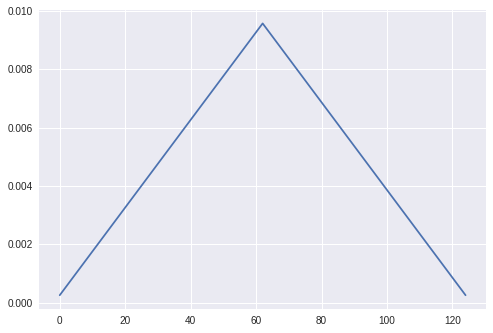

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(l_rates)

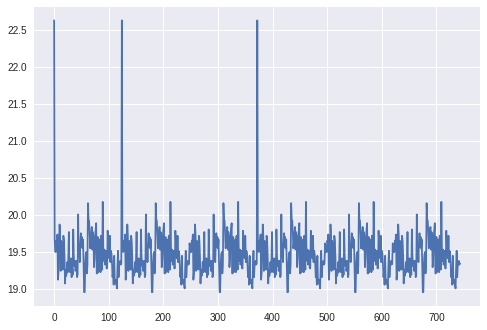

In [0]:
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_v_losses)

In [0]:
# generate translations
# maybe try to implement beam search

sequence = "Go away!"
coded_seq = torch.zeros((1, max_eng_seq_len, num_eng_chars)).cuda()
si = 10

for i, ch in enumerate(sequence):
  coded_seq[0, i, ch2idx_fra[ch]] = 1


# _, (hs, cs) = e(eng_seqs[si].unsqueeze(0))
_, (hs, cs) = e(coded_seq)
translation = "\t"
targ_seq = torch.zeros((1, 1, num_fra_chars)).cuda()
targ_seq[0, 0, ch2idx_fra[translation]] = 1 #this one hot encoding is super cumbersome

i = 1
while i < max_fra_seq_len:
  # i think we need the hidden_states out of the dec lstm
  out, (hs, cs) = d(targ_seq, (hs, cs))
  idx = torch.argmax(out)
  targ_seq = torch.zeros((1, 1, num_fra_chars)).cuda()
  targ_seq[0, 0, idx] = 1
  ch = idx2ch_fra[idx]
  translation += ch
  
  if ch == '\n':
    break
  
  i += 1
  
print(translation)
# print('\t' + inp_txts[si] + '\n')

	Ce surais la pais.

